# ImageNet PaliGemma SAE Training

### Import libraries and define SAE class

In [11]:
import sys, ipykernel, jupyter_server, os
print(sys.executable)
print("ipykernel:", ipykernel.__version__)
print("jupyter_server:", jupyter_server.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3, 5, 6"

/home/henrytsai/anaconda3/envs/ishan/bin/python
ipykernel: 6.29.5
jupyter_server: 2.15.0


In [12]:
print("Visible GPUs :", DEVICES)
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))
print("Subset sizes :", [len(s) for s in subsets])


Visible GPUs : ['cuda:2', 'cuda:3', 'cuda:5', 'cuda:6']
0 NVIDIA A100-SXM4-40GB
1 NVIDIA A100-SXM4-40GB
2 NVIDIA A100-SXM4-40GB
3 NVIDIA A100-SXM4-40GB
Subset sizes : [25, 25, 25, 25]


In [13]:
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
from concurrent.futures import ThreadPoolExecutor
from torchvision.utils import make_grid
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import wandb
from datetime import datetime
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import multiprocessing
from datasets import Dataset
import numpy as np
from PIL import Image
from IPython import display

DIM_IN = 2048
DIM_HIDDEN = 4096

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=DIM_IN, d_hidden=DIM_HIDDEN):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

dtype = torch.float16
if torch.cuda.is_available():
    torch.cuda.set_device(2)  # Set current device to 1
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    dtype = torch.bfloat16

device = "cuda:2" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda:2


In [5]:
torch.cuda.empty_cache()    # Clears unreferenced memory
gc.collect()  

324

In [6]:
# --------- helpers you already wrote ----------
NUM_FRAMES = 6               # grid uses evenly spaced frames
FRAMES_PER_ROW = 3          

def preprocess_image(im: Image.Image) -> Image.Image:
    return im.resize((896, 896), Image.BILINEAR)   # <‑‑ used ONLY for display

def subsample_frames(images, num_samples):
    if len(images) <= num_samples:
        return images
    idx = np.linspace(0, len(images)-1, num=num_samples, dtype=int)
    return [images[i] for i in idx]

def stack_images_horizontally(imgs):
    w, h = zip(*(im.size for im in imgs))
    canvas = Image.new("RGB", (sum(w), max(h)))
    x = 0
    for im in imgs:
        canvas.paste(im, (x, 0))
        x += im.width
    return canvas

def stack_images_grid(imgs, frames_per_row=FRAMES_PER_ROW):
    rows = [imgs[i:i+frames_per_row] for i in range(0, len(imgs), frames_per_row)]
    rows = [stack_images_horizontally(r) for r in rows]
    as_np = np.vstack([np.asarray(r) for r in rows])
    return Image.fromarray(as_np)
# ----------------------------------------------


### Loading DROID dataset

In [7]:
import multiprocessing as mp
from PIL import Image
import tensorflow_datasets as tfds

def load_droid_subset(return_dict):
    ds = tfds.load("droid_100", split="train", data_dir="gs://gresearch/robotics")

    frames, prompts = [], []
    for episode in ds.take(100):                        # ←‑‑ keep your 10‑episode cap
        steps = list(episode["steps"])

        # ------- build the 8‑frame grid -------
        all_imgs = [Image.fromarray(step["observation"]["wrist_image_left"].numpy())
                    for step in steps]

        # pick evenly spaced frames
        sampled = subsample_frames(all_imgs, NUM_FRAMES)

        # build H×W grid (typically 4×2) and resize to 896x896
        grid_pil  = stack_images_grid(sampled)          # produced by helper above
        grid_pil  = grid_pil.resize((896, 896), Image.BILINEAR)

        # --------------------------------------

        frames.append(grid_pil)     # **store the PIL grid**
        prompts.append(steps[0]["language_instruction"].numpy().decode("utf-8"))

    return_dict["frames"]  = frames
    return_dict["prompts"] = prompts

manager = multiprocessing.Manager()
return_dict = manager.dict()
p = multiprocessing.Process(target=load_droid_subset, args=(return_dict,))
p.start()
p.join()

frames, prompts = return_dict["frames"], return_dict["prompts"]

2025-05-04 06:29:26.252255: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-05-04 06:29:26.252327: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:167] env: CUDA_VISIBLE_DEVICES="2, 3, 5, 6"
2025-05-04 06:29:26.252357: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-05-04 06:29:26.252369: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: cs182-vm3
2025-05-04 06:29:26.252373: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: cs182-vm3
2025-05-04 06:29:26.252464: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version

In [8]:
from torch.utils.data import Dataset, Subset

class DroidDataset(Dataset):
    def __init__(self, imgs, caps):
        self.imgs  = imgs         # list of PIL images (grids)
        self.caps  = caps         # list of strings
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return {"image": self.imgs[idx],
                "prompt": self.caps[idx]}

dataset = DroidDataset(frames, prompts)

### Load model (takes 55 seconds)

In [9]:
MODEL_ID = "google/paligemma2-3b-pt-896"

model = PaliGemmaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype
).eval()
model = model.to(device) # Move model to GPU
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Set up activation capture (vision tower)
vision_acts = {}
def vision_hook(module, input, output):
    vision_acts["activation"] = output

hook_handle = model.vision_tower.vision_model.encoder.layers[20].register_forward_hook(vision_hook)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.73it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
import copy
from threading import Thread
from functools import partial

# === Config ===
BATCH_SIZE = 32 # max size withou OOM error
NUM_WORKERS = 8

def collate_fn(batch):
    images = [example["image"] for example in batch]
    prompts = [example["prompt"] for example in batch]
    return {"images": images, "prompts": prompts}

# === Split dataset across 2 GPUs ===

# ------------ 1.  constants ------------
DEVICES = ["cuda:0", "cuda:1", "cuda:2", "cuda:3"]
NUM_GPUS = len(DEVICES)
quarter   = len(dataset) // NUM_GPUS

# ------------ 2.  split dataset ------------
subsets = [Subset(dataset, range(i*quarter, (i+1)*quarter if i < NUM_GPUS-1 else len(dataset)))
           for i in range(NUM_GPUS)]

# ------------ 3.  build dataloaders ------------
dataloaders = [DataLoader(s,
                          batch_size=BATCH_SIZE,
                          collate_fn=collate_fn,
                          num_workers=NUM_WORKERS,
                          pin_memory=True)
               for s in subsets]

# ------------ 4.  replicate model ------------
models = [copy.deepcopy(model) for _ in range(NUM_GPUS)]
vision_stores = [{} for _ in range(NUM_GPUS)]          # one dict per GPU
hook_handles  = []

for i, m in enumerate(models):
    # create an isolated hook for each replica
    def make_hook(store):
        return lambda _mod, _inp, out: store.__setitem__("activation", out)
    h = m.vision_tower.vision_model.encoder.layers[20].register_forward_hook(
            make_hook(vision_stores[i])
    )
    hook_handles.append(h)

# ------------ 5.  inference worker ------------
def run_inference(model, store, loader, device, acts_out, counts_out):
    model.to(device).eval()
    for batch in tqdm(loader, desc=f"Inference {device}"):
        try:
            model_inputs = processor(
                text=batch["prompts"],
                images=batch["images"],
                return_tensors="pt",
                padding=True
            )
            model_inputs = {k: v.to(device, non_blocking=True)
                            for k, v in model_inputs.items()}

            with torch.no_grad(), autocast(dtype=torch.bfloat16):
                _ = model(**model_inputs)

            act = store["activation"]
            if isinstance(act, tuple):
                act = act[0]

            acts_out.append(act.cpu().float())
            counts_out.extend([act.shape[1]] * act.size(0))
        except Exception as e:
            print(f"[{device}]  skipped batch: {e}")

# ------------ 6.  launch threads ------------
activation_lists = [[] for _ in range(NUM_GPUS)]
token_counts     = [[] for _ in range(NUM_GPUS)]
threads          = []

for i in range(NUM_GPUS):
    t = Thread(target=run_inference,
               args=(models[i], vision_stores[i],
                     dataloaders[i], DEVICES[i],
                     activation_lists[i], token_counts[i]))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# ------------ 7.  merge & cleanup ------------
all_activations = torch.cat([torch.cat(lst) for lst in activation_lists], dim=0)
image_tok_cnts  = sum(token_counts, [])

for h in hook_handles:
    h.remove()
del models, hook_handles, vision_stores, activation_lists, token_counts
gc.collect(); torch.cuda.empty_cache()

print("Collected activations:", all_activations.shape)
print("Sum of tokens recorded:", sum(image_tok_cnts))


Exception in thread Thread-8 (run_inference):
Traceback (most recent call last):
  File "/home/henrytsai/anaconda3/envs/ishan/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
Exception in thread Thread-9 (run_inference):
Traceback (most recent call last):
  File "/home/henrytsai/anaconda3/envs/ishan/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/home/henrytsai/anaconda3/envs/ishan/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    self.run()
  File "/home/henrytsai/anaconda3/envs/ishan/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/henrytsai/anaconda3/envs/ishan/lib/python3.11/threading.py", line 982, in run
    _threading_Thread_run(self)
  File "/home/henrytsai/anaconda3/envs/ishan/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_499119/951497852.py", line 49, in

[cuda:2]  skipped batch: CUDA out of memory. Tried to allocate 1.77 GiB. GPU 2 has a total capacity of 39.49 GiB of which 1.53 GiB is free. Including non-PyTorch memory, this process has 37.96 GiB memory in use. Of the allocated memory 32.02 GiB is allocated by PyTorch, and 5.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Inference cuda:3: 100%|████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.12s/it]

[cuda:3]  skipped batch: CUDA out of memory. Tried to allocate 49.24 GiB. GPU 3 has a total capacity of 39.49 GiB of which 15.48 GiB is free. Including non-PyTorch memory, this process has 24.00 GiB memory in use. Of the allocated memory 18.42 GiB is allocated by PyTorch, and 5.09 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


RuntimeError: torch.cat(): expected a non-empty list of Tensors

### Save to disk

In [83]:
# Convert to half precision before saving (cuts size in half)
all_activations_fp16 = all_activations.half()
torch.save(all_activations_fp16, "all_activations_fp16.pt")
torch.save(image_to_token_counts, "image_to_token_counts.pt")

### Train SAE

In [86]:
# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 128,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# === Prepare SAE ===
d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to("cuda:2") 
# sae = nn.DataParallel(sae)  # Now wrap for multi-GPU
optimizer = torch.optim.AdamW(sae.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# === Dataset & Loader ===

train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Epoch 5: Loss 1.230927
Epoch 10: Loss 1.064376
Epoch 15: Loss 0.925210
Epoch 20: Loss 0.810211
Epoch 25: Loss 0.722722
Epoch 30: Loss 0.641120
Epoch 35: Loss 0.574024
Epoch 40: Loss 0.516602
Epoch 45: Loss 0.466797
Epoch 50: Loss 0.425332
Finished training Sparse Autoencoder!
Saved SAE to checkpoints/sae_2025-05-04_01-47-24.pth


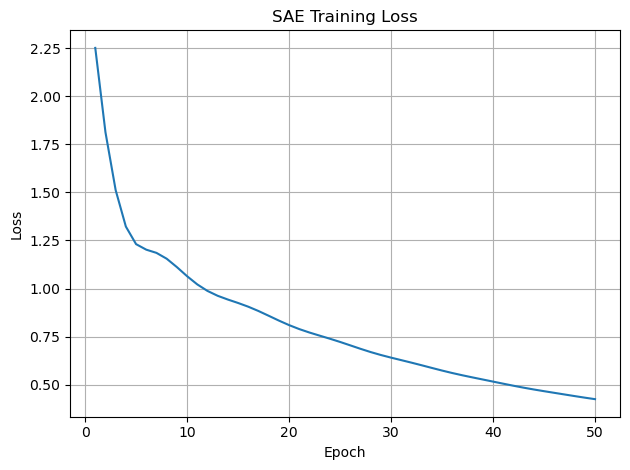

In [87]:
device = "cuda:2"

sae = sae.to(device)          # no DataParallel
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-4)

epoch_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for (batch,) in train_loader:          # iterate gives a tuple
        batch = batch.to(device, non_blocking=True)

        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + sparsity_weight * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)
    wandb.log({"loss": avg_loss, "epoch": epoch + 1})
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")

print("Finished training Sparse Autoencoder!")

# === Save model with timestamp ===
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")

torch.save({
    "state_dict": sae.state_dict(),
    "d_in": d_in,
    "d_hidden": d_hidden,
}, model_path)
wandb.save(model_path)

print(f"Saved SAE to {model_path}")

# === Plot loss curve (optional) ===
plt.plot(range(1, n_epochs + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

### Load previously trained model

In [97]:
# Need to change model path to your own local folder and .pth filename
model_path = "/home/henrytsai/ishan/roboterp/checkpoints/sae_2025-05-04_01-47-24.pth"

# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 512,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# ==== LOAD METADATA ====
image_to_token_counts = torch.load("image_to_token_counts.pt")
all_activations = torch.load("all_activations_fp16.pt", map_location="cpu")  # shape: [N_images, T, D]
all_activations = all_activations.view(-1, all_activations.shape[-1])        # -> [N_tokens, D]

d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

# Define the model
sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden)
state_dict = torch.load(model_path, map_location=device)["state_dict"]

# If saved with DataParallel, strip 'module.' prefix
from collections import OrderedDict
if any(k.startswith("module.") for k in state_dict):
    new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
    state_dict = new_state_dict

# Apply weights
sae.load_state_dict(state_dict)
sae = sae.to(device)
sae.eval()

# Setup SAE model
sae_device = sae.encoder.weight.device
sae_dtype = sae.encoder.weight.dtype

/tmp/ipykernel_142298/4208252985.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_to_token_counts = torch.load("image_to_token_counts.pt")
/tmp/ipykernel_142298/42

### Visualize features

Top 10 active features: [2831, 8707, 2104, 5955, 337, 2478, 5518, 1922, 8834, 2445]


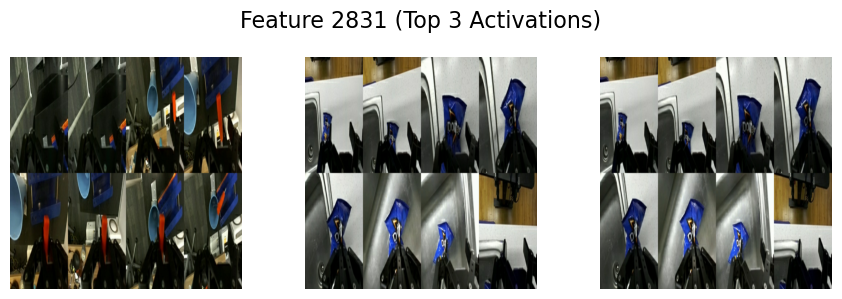

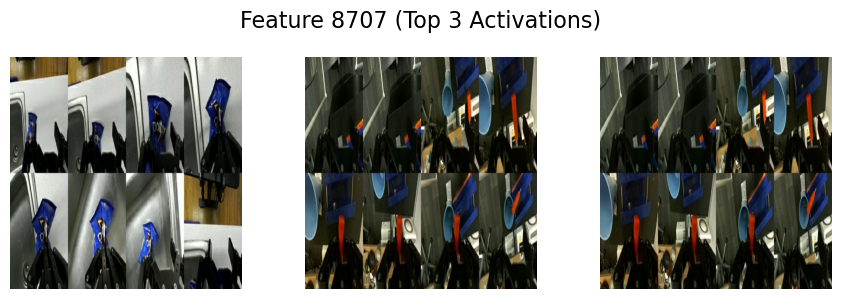

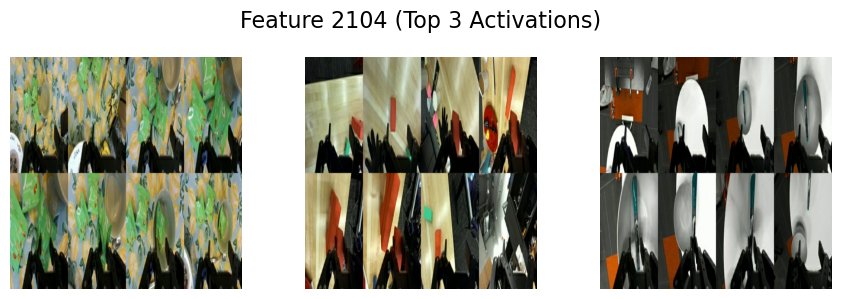

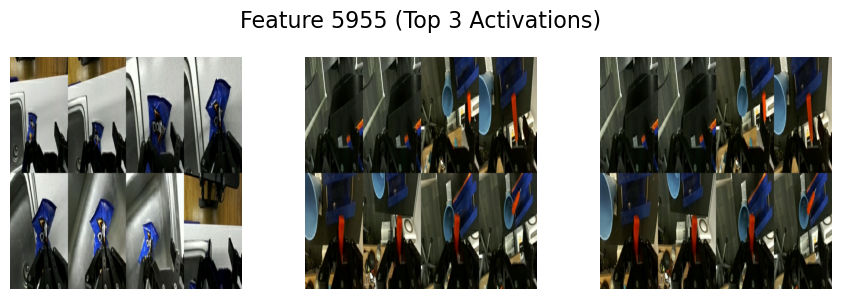

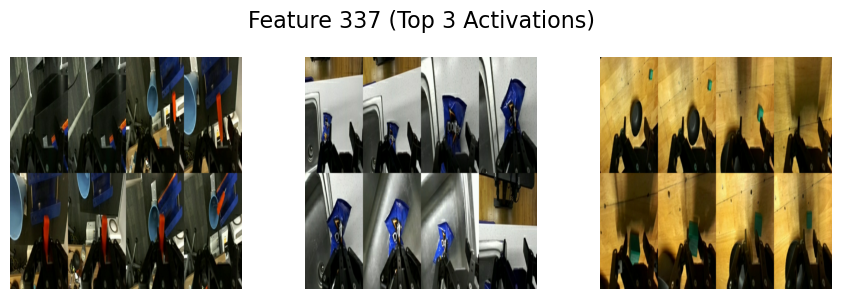

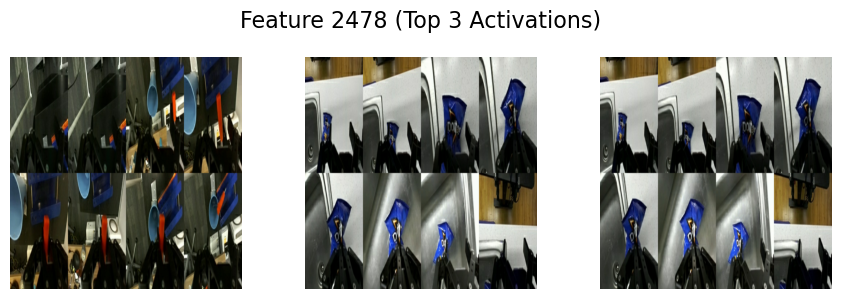

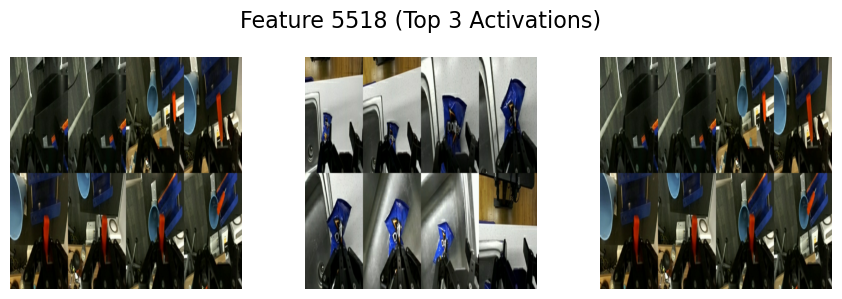

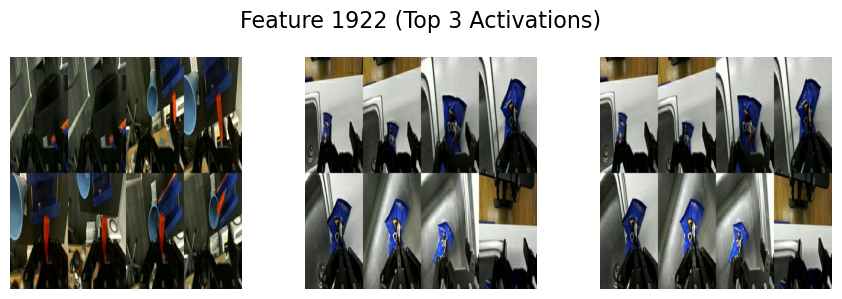

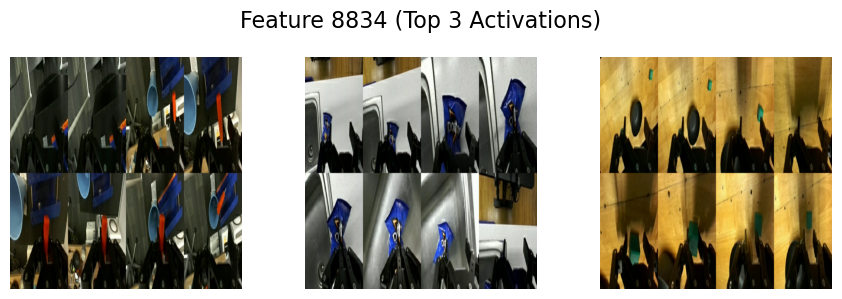

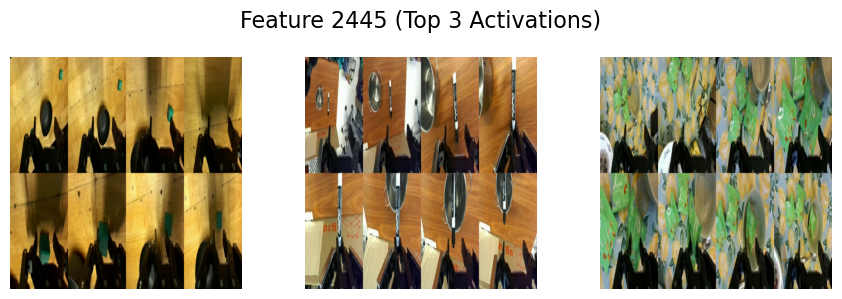

In [100]:
# ==== CONFIG ====
top_k = 3
n_features_to_plot = 10
batch_size = 4096  # tune based on your GPU memory
num_workers = 8    # number of parallel CPU threads


# ==== STREAM ENCODE ====
sparse_feature_list = []
running_sum = torch.zeros(sae.decoder.in_features, device=sae_device)
count = 0

with torch.no_grad():
    for i in range(0, all_activations.size(0), batch_size):
        batch = all_activations[i:i + batch_size].to(device=sae_device, dtype=sae_dtype)
        sparse = sae.activation(sae.encoder(batch))
        running_sum += sparse.sum(dim=0)
        count += sparse.size(0)
        sparse_feature_list.append(sparse.cpu())

sparse_features = torch.cat(sparse_feature_list, dim=0)

# ==== TOKEN-TO-IMAGE INDEX MAPPING ====
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)

assert len(image_indices_per_token) == sparse_features.shape[0], \
    f"Mismatch: {len(image_indices_per_token)} vs {sparse_features.shape[0]}"

image_indices_per_token = np.array(image_indices_per_token)

# ==== TOP FEATURES ====
mean_features = running_sum / count
top_features = torch.topk(mean_features, k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} active features:", top_features)

# ==== PARALLEL IMAGE LOADING ====
def load_rgb(idx):
    img_idx = int(image_indices_per_token[idx])
    image = dataset[img_idx]["image"].convert("RGB")
    return np.array(image)

# ==== DISPLAY ====
for feature_idx in top_features:
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    # Load top images in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(load_rgb, topk_indices))

    # Plot
    fig, axes = plt.subplots(1, top_k, figsize=(3 * top_k, 3))
    axes = [axes] if top_k == 1 else axes
    fig.suptitle(f"Feature {feature_idx} (Top {top_k} Activations)", fontsize=16)

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Sparsity analysis

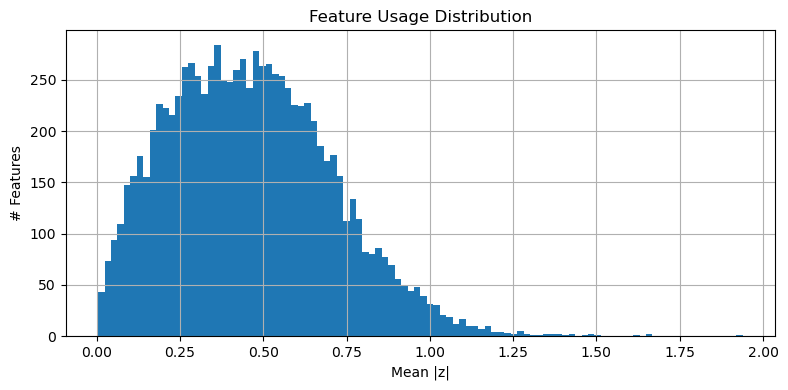

In [92]:
# Assume `sae` is already loaded and on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sae = sae.to(device)
sae.eval()

# Compute feature usage (mean |z|) without storing all z
d_hidden = sae.module.encoder.out_features if isinstance(sae, torch.nn.DataParallel) else sae.encoder.out_features
running_sum = torch.zeros(d_hidden, device=device)
count = 0

with torch.no_grad():
    for (batch,) in train_loader:
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)                      # shape: [B, d_hidden] or [B, T, d_hidden]
        z = z.view(-1, z.shape[-1])            # flatten in case it's [B, T, d_hidden]
        running_sum += torch.sum(torch.abs(z), dim=0)
        count += z.shape[0]

feature_usage = running_sum / count

# Plot
plt.figure(figsize=(8, 4))
plt.hist(feature_usage.cpu().numpy(), bins=100)
plt.title("Feature Usage Distribution")
plt.xlabel("Mean |z|")
plt.ylabel("# Features")
plt.grid(True)
plt.tight_layout()
plt.show()


### Clean up memory

In [12]:
# del [insert variable]
del d_hidden
torch.cuda.empty_cache()
gc.collect()

650